In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import glob
import os
import matplotlib.pyplot as plt
import math

#Umap
import matplotlib.pyplot as plt
from umap import UMAP
import umap

from pointgrid import align_points_to_grid

# t-SNE
from sklearn.manifold import TSNE
from sklearn.manifold import trustworthiness

#Wordclouds
from wordcloud import WordCloud
from PIL import Image, ImageDraw

from os import path
import multidict as multidict

from scipy.spatial import ConvexHull
from scipy import interpolate

# Data

In [2]:
# Import

path_in = 'data/csv/freihand_signatures.csv'

df = pd.read_csv(path_in)

# Export 

columns_export =['id', 'lang', 'title', 'year', 'embedding_x', 'embedding_y', 'cluster', 'subject_list']

path_out = '../BHVizApp/src/data/mapping_out_sample.csv'

In [3]:
df = df.sample(10000)

## Word Tokenization

In [6]:
# vectorizer = CountVectorizer(min_df=5)
# subject_doc_matrix = vectorizer.fit_transform(df.subject_list)

tfidf = TfidfVectorizer(min_df=5)
subject_doc_matrix = tfidf.fit_transform(df.subject_list)

# Dimensionality Reduction

### UMAP

In [7]:
# reducer = UMAP(random_state=42, n_components = 2, metric='cosine')

# Using hellinger metric the points without neighbors are mapped to nan.
reducer = UMAP(random_state=42, n_components = 2, min_dist=0.01, n_neighbors=3, metric='cosine') 
umap_emb = reducer.fit_transform(subject_doc_matrix)


c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\umap\spectral.py:260: UserWarning: WARN

### t-SNE

In [8]:
reducer = TSNE(n_components=2)
tsne_emb = reducer.fit_transform(subject_doc_matrix)

c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


### Evaluation

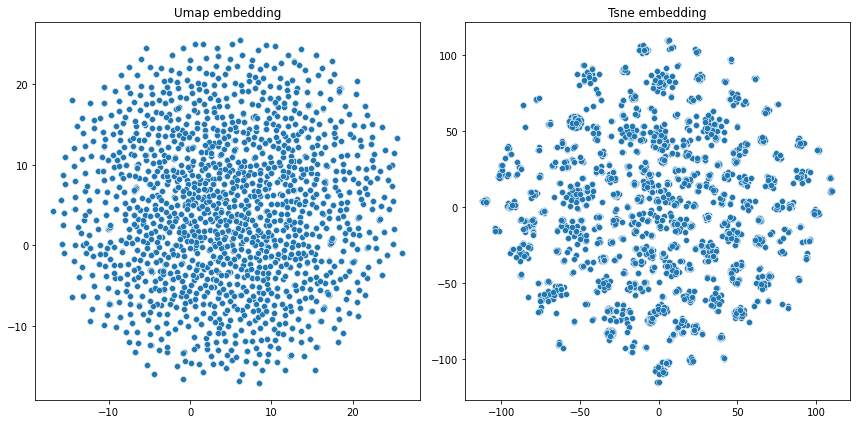

In [9]:
# Plotting

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot UMAP
sns.scatterplot(ax= axes[0], x=umap_emb[:,0], y=umap_emb[:,1], legend='full')
axes[0].set_title('Umap embedding')

# Plot tsne
sns.scatterplot(ax= axes[1], x=tsne_emb[:,0], y=tsne_emb[:,1], legend='full')
axes[1].set_title('Tsne embedding')

plt.tight_layout()
plt.show()

In [10]:
# Calculate trustworthiness and continuity for UMAP
umap_tw = trustworthiness(subject_doc_matrix, umap_emb, n_neighbors=10)
#umap_cn = UMAP(n_neighbors=5, min_dist=0.3).fit(subject_doc_matrix).score(subject_doc_matrix)

# Calculate trustworthiness and continuity for t-SNE
tsne_tw = trustworthiness(subject_doc_matrix, tsne_emb, n_neighbors=10)
#tsne_cn = TSNE(n_components=2, perplexity=30, learning_rate=200).fit(subject_doc_matrix).kl_divergence_

print(f"UMAP Trustworthiness: {umap_tw:.3f}")
print(f"t-SNE Trustworthiness: {tsne_tw:.3f}")


UMAP Trustworthiness: 0.881
t-SNE Trustworthiness: 0.999


## Export the embedding

In [11]:
emb = tsne_emb

### Scale embedding

In [12]:
# Normalize 

embedding = emb * 100 # Multiply by 100
embedding = align_points_to_grid(embedding)

# Swap axes for horizontal position

ptp = np.ptp(embedding, axis=0)
if ptp[1]> ptp[0]:
    embedding[:, [1, 0]] = embedding[:, [0, 1]]

# Set value starting from 0

embedding[:, 0] = embedding[:, 0] - embedding[:, 0].min()
embedding[:, 1] = embedding[:, 1] - embedding[:, 1].min()

# # Set origin at the middle

ptp = np.ptp(embedding, axis=0)  
embedding[:, 0] = embedding[:, 0] - ptp[0] / 2
embedding[:, 1] = embedding[:, 1] - ptp[1] / 2

embedding = embedding.astype(int) # Set integer

embedding

array([[   213,  -1821],
       [   142, -11001],
       [ -4622,  -3643],
       ...,
       [  -853,    350],
       [ -3342,  -1121],
       [ -1280,  -6236]])

# Cluster Identification

In [13]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=50, cluster_selection_method ='leaf')

clusterer.fit(embedding)
clusters = clusterer.labels_

# add cluster to dataframe

df['cluster'] = clusters

#Grouping by cluster

values = set(clusters)
if -1 in values: values.remove(-1)

clusters = [[index for index, cluster in enumerate(clusters) if cluster==value] for value in values]

# Wordclouds

In [14]:
for index, cluster in enumerate(clusters):

    # Preprocessing

    scale = 1
    
    min_X = min([i[0] for i in embedding[cluster]]) * scale
    max_X = max([i[0] for i in embedding[cluster]]) * scale
    min_Y = min([i[1] for i in embedding[cluster]]) * scale
    max_Y = max([i[1] for i in embedding[cluster]]) * scale

    width = max_X - min_X; height = max_Y - min_Y
    
    #points = list(map(lambda i: (i[0] * scale - min_X, i[1] * scale - min_Y), embedding[cluster]))
    points = [(i[0] * scale - min_X, i[1] * scale - min_Y) for i in embedding[cluster]]

    # Hull

    hull = ConvexHull(points)

    x_hull = np.append(hull.points[hull.vertices,0], hull.points[hull.vertices,0][0])
    y_hull = np.append(hull.points[hull.vertices,1], hull.points[hull.vertices,1][0])
    
    # Interpolation
    
    dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
    dist_along = np.concatenate(([0], dist.cumsum()))
    spline, u = interpolate.splprep([x_hull, y_hull], u=dist_along, s=0)
    interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
    interp_x, interp_y = interpolate.splev(interp_d, spline)    
    interp_points = list(zip(interp_x, interp_y))

    # Create mask

    print(width, height)
    img = Image.new(mode = "RGBA", size = (width, height), color = (255, 255, 255))
    draw = ImageDraw.Draw(img)
    # draw.polygon(points, fill=(0,0,0))
    draw.polygon(interp_points, fill=(0,0,0))
    mask = np.array(img)


    # Collect text

    text = []
    for id in cluster:
        text.append(df.iloc[id]['subject_list'])
    text = ' '.join(text)
    # text = text.replace('datum', 'data')
    # text = text.replace('medium', 'media')
    dictionary = multidict.MultiDict()
    _dictionary = {}


    # Frequency

    for _word in text.split(" "):
        val = _dictionary.get(_word, 0)
        _dictionary[_word] = val + 1
    for key in _dictionary:
        dictionary.add(key, _dictionary[key])


    # Wordcloud

    max_words = math.ceil(len(dictionary)*.1)


    wc = WordCloud(
        mode = "RGBA",
        color_func=lambda *args, **kwargs: (0, 0, 0),
        font_path = 'Lato-Regular.ttf',
        mask=mask,
        
        normalize_plurals=False,
        prefer_horizontal= 1,
        
        margin=40,

        background_color=None,
        # background_color='black',

        # max_words=max_words,
        
        min_font_size= 10,
        max_font_size= 100,
        # collocation_threshold = 20,
        relative_scaling = 0,
    )

    print(index, max_words, '-', end=' ')
    
    wc.generate_from_frequencies(dictionary) # generate word cloud
    file_path = path.join('data/' + f"{index:02}.png")
    wc.to_file('../BHVizApp/src/wordclouds/'+f"{index:02}.png") # store to file

2276 2593
0 6 - 1493 2031
1 6 - 854 631
2 2 - 1066 2452
3 4 - 1138 1261
4 3 - 1494 1472
5 9 - 2703 2453
6 8 - 2632 1612
7 6 - 2205 1261
8 4 - 925 700
9 5 - 1279 1121
10 7 - 1351 1261
11 9 - 1138 1051
12 7 - 1636 1752
13 8 - 1635 1191
14 4 - 1209 1402
15 6 - 924 911
16 2 - 1280 1262
17 3 - 1992 1891
18 6 - 996 1121
19 2 - 925 981
20 2 - 1777 1262
21 8 - 2134 1051
22 6 - 1067 1121
23 6 - 1636 2102
24 7 - 1778 2241
25 7 - 2560 2032
26 4 - 2631 1682
27 5 - 1778 2313
28 11 - 2347 1401
29 8 - 1849 2242
30 2 - 853 1471
31 5 - 1493 1542
32 5 - 1066 981
33 4 - 1565 3434
34 5 - 1992 2102
35 5 - 1067 1401
36 3 - 1636 911
37 3 - 996 911
38 2 - 3343 2873
39 11 - 782 841
40 2 - 1636 1401
41 15 - 1707 2383
42 10 - 1351 1612
43 8 - 1494 1891
44 7 - 1920 1542
45 5 - 1351 2382
46 8 - 925 1121
47 3 - 2774 3362
48 8 - 1422 3923
49 6 - 2561 1121
50 7 - 1493 2031
51 5 - 

# Export

In [17]:
# add coordinates to dataframe

df['embedding_x']  = embedding[:,0]
df['embedding_y']  = embedding[:,1]

df['id'] = df.bvb
df['title'] = df.title_x
df['year'] = df.year_y

df[columns_export].to_csv(path_out, index=False)